In [278]:
def get_sigma(x, sigma):
    for n in range(len(x)):
        if x[n] <13:
            precision = 8*(10**(-3))
        elif x[n] < 18:
            precision = 16*(10**(-3))
        else:
            precision = 200*(10**(-3))
        sigma.append(np.sqrt(2*precision**2))
    sigma = np.array(sigma)
    return sigma

In [279]:
def rejection(x_s1, y_s1, outliers_5sigma, y_5sigma):
    # get the difference between the values predicted by the model and the actual bp-rp values
    for j in range(20):
        diff = []
        model = UnivariateSpline(x_s1, y_s1, k=4)
        predicted = model(x_s1)
        # get the difference between the values predicted by the model and the actual bp-rp values
        diff = y_s1 - predicted

        #get the standard deviation of the differences
        sigma = []
        sigma = get_sigma(x_s1, sigma)
        x_filtered = []
        y_filtered = []
        if j == 0:
            for k in range(len(diff)):
                if np.abs(diff[k]) >= 10*sigma[k]: #and 13<= x_s1[k]< 18:
                    outliers_5sigma.append(x_s1[k])
                    y_5sigma.append(y_s1[k])

                else:
                    x_filtered.append(x_s1[k])
                    y_filtered.append(y_s1[k])
            x_s1 = x_filtered
            y_s1 = y_filtered
        else:
            for k in range(len(diff)):
                if np.abs(diff[k]) >= 5*sigma[k]:
                    outliers_5sigma.append(x_s1[k])
                    y_5sigma.append(y_s1[k])
                else:
                    x_filtered.append(x_s1[k])
                    y_filtered.append(y_s1[k])
            x_s1 = x_filtered
            y_s1 = y_filtered
        
    return x_s1, y_s1,outliers_5sigma, y_5sigma, model

In [280]:
def segments(df, cluster_name):
    x_s1=[]
    y_s1=[]
    x_s2=[]
    y_s2=[]
    x_non_ms=[]
    y_non_ms=[]
    df_cluster = df[(df['Cluster']==cluster_name)]
    df_cluster.dropna(subset = ['gmag','rpmag','bpmag'], inplace = True)
    df_cluster.sort_values(by=['gmag'], inplace=True)
    x = np.array(df_cluster['gmag'])
    y = np.array(df_cluster['bpmag']- df_cluster['rpmag'])
    x_turn = turnoff(x,y)
    #function needed to exclude non main sequence
    for i in range(len(x)):
        if (x[i]<=13 and x[i] >= x_turn):
            x_s1.append(x[i])
            y_s1.append(y[i])
        elif(x[i]>13):
            x_s2.append(x[i])
            y_s2.append(y[i])
        elif(x[i]<x_turn):
            x_non_ms.append(x[i])
            y_non_ms.append(y[i])
    return x_s1, y_s1, x_s2, y_s2, x_non_ms, y_non_ms

In [281]:
def turnoff(x,y):
    x_copy = x
    y_copy = y
    x_rej=[]
    y_rej=[]
    x_filtered = []
    y_filtered = []
    x_turn = x_copy[0]
    for j in range(2):
        diff = []
        model = UnivariateSpline(x_copy, y_copy, k=4)
        predicted = model(x_copy)

        # get the difference between the values predicted by the model and the actual bp-rp values
        diff = y_copy - predicted

        #get the standard deviation of the differences
        sigma = []
        sigma = get_sigma(x_copy,sigma)
        x_critical = model.derivative().roots()
        for i in range(len(x_critical)):
            if model.derivatives(x_critical[i])[2]>0:
                x_turn = x_critical[i]
        if(j == 0):
            for k in range(len(diff)):
                if np.abs(diff[k]) < 20*sigma[k] or x_copy[k] <= x_turn: #and 13<= x_s1[k]< 18:
                    x_filtered.append(x_copy[k])
                    y_filtered.append(y_copy[k])
                elif diff[k] >= 20*sigma[k] and x_copy[k] > x_turn:
                    x_rej.append(x_copy[k])
                    y_rej.append(y_copy[k])
        x_copy = x_filtered
        y_copy = y_filtered
    return x_turn

In [282]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

In [283]:
with fits.open('NearbyClustersGaia_GALEX_SDSS_Skymapper_2MASS_WISE_ASASSN.fits') as hdu:
    asn_table = Table(hdu[1].data)
df = asn_table.to_pandas()
x_s1, y_s1, x_s2, y_s2, x_non_ms, y_non_ms = segments(df,'alphaPer')

<ipython-input-280-1d0537f7a549>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster.dropna(subset = ['gmag','rpmag','bpmag'], inplace = True)
<ipython-input-280-1d0537f7a549>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster.sort_values(by=['gmag'], inplace=True)


In [285]:
outliers_5sigma=[]
y_5sigma = []
x_s1, y_s1, outliers_5sigma, y_5sigma, model = rejection(x_s1, y_s1, outliers_5sigma, y_5sigma)
x_s2, y_s2, outliers_5sigma, y_5sigma,model1 = rejection(x_s2, y_s2, outliers_5sigma, y_5sigma)

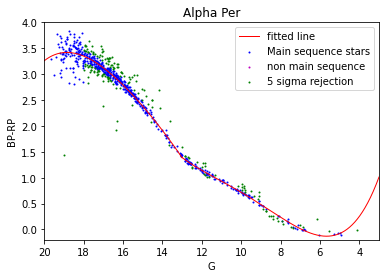

In [286]:
# plot the good values alongside the rejected values and the fitted line
plt.xlim(20,3)
plt.ylim(-0.2,4)
xs = np.linspace(3, 13, 1000)
xs1 = np.linspace(13,20,1000)
plt.plot(xs, model(xs), 'r', label = 'fitted line',lw=1)
plt.plot(xs1, model1(xs1), 'r', lw=1)
plt.scatter(x_s2, y_s2, c = 'b', label = 'Main sequence stars', s = 1)
plt.scatter(x_s1, y_s1, c = 'b', s = 1)
plt.scatter(x_non_ms, y_non_ms , c = 'm', label = 'non main sequence', s = 1)
#plt.scatter(PMS_x, PMS_y, c = 'c', label = 'iso PMS', s=1)
plt.scatter(outliers_5sigma, y_5sigma, c = 'g', label = '5 sigma rejection', s=1)
#plt.scatter(outliers_2sigma, y_2sigma, c = 'm',label = '2 sigma rejection', s=1)
plt.xlabel('G')
plt.ylabel('BP-RP')

#plt.plot(x_lin_reg1, y_lin_reg1, c = 'r', label='Fitted line1')
plt.title('Alpha Per')
plt.legend()
plt.show()

In [288]:
x_filtered = x_s1+x_s2
y_filtered = y_s1+y_s2

for i in range(len(outliers_5sigma)):
    if(outliers_5sigma[i]>=13 and y_5sigma[i]< model(outliers_5sigma[i])):
        x_filtered.append(outliers_5sigma)
        y_filtered.append(y_5sigma)
    elif(outliers_5sigma[i]<13 and y_5sigma[i]< model1(outliers_5sigma[i])):
        x_filtered.append(outliers_5sigma)
        y_filtered.append(y_5sigma)

In [289]:
x_filtered

[4.9245744,
 4.995555,
 5.0999603,
 5.2751575,
 6.0592294,
 6.742422,
 6.814468,
 6.8523498,
 6.9125996,
 7.122177,
 7.1509724,
 7.2609167,
 7.3522315,
 7.6039004,
 7.6058197,
 7.6279936,
 7.6962194,
 7.924273,
 8.086543,
 8.139169,
 8.731082,
 8.912741,
 8.915356,
 8.972591,
 9.080628,
 9.090114,
 9.098938,
 9.113573,
 9.376285,
 9.472725,
 9.518273,
 9.601711,
 9.614338,
 9.62332,
 9.629821,
 9.647073,
 9.772757,
 9.803326,
 9.848345,
 9.885712,
 9.912576,
 9.943663,
 9.981635,
 9.986203,
 10.073476,
 10.145709,
 10.170762,
 10.198616,
 10.231224,
 10.24944,
 10.253608,
 10.325752,
 10.424097,
 10.501652,
 10.536014,
 10.731298,
 10.73468,
 10.850994,
 10.931871,
 10.94589,
 10.985395,
 10.988854,
 11.097515,
 11.133807,
 11.346774,
 11.400254,
 11.425021,
 11.462829,
 11.466343,
 11.47506,
 11.629309,
 11.654486,
 11.672612,
 11.678541,
 11.743715,
 11.7447605,
 11.752284,
 11.770886,
 11.809672,
 11.844377,
 11.924691,
 11.974664,
 11.9766865,
 11.996798,
 12.002465,
 12.042795,
 1